# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.427885,True,-0.132639
1,-1.633434,False,-4.257470
2,-0.183799,True,5.041262
3,0.166076,True,5.654281
4,-0.986367,True,2.859386
...,...,...,...
995,0.222462,True,4.403516
996,-0.556553,False,-2.077173
997,0.456314,False,2.475070
998,-0.859203,True,2.344173


<AxesSubplot:xlabel='v0'>

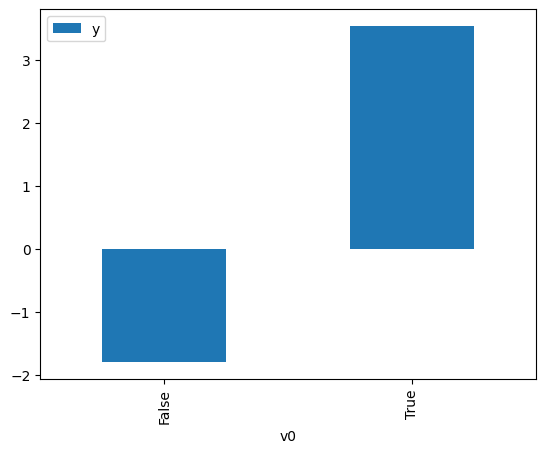

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

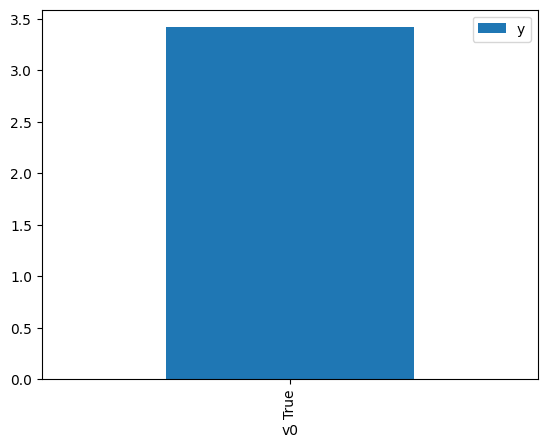

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.326868,False,2.490630,0.495777,2.017036
1,0.586008,False,2.229718,0.507674,1.969768
2,-0.029041,False,-0.746650,0.517545,1.932200
3,-0.390415,False,-4.618574,0.523338,1.910809
4,-0.280086,False,1.338244,0.521570,1.917288
...,...,...,...,...,...
995,1.439728,False,4.653882,0.493965,2.024436
996,-0.654531,False,-1.935915,0.527569,1.895487
997,-1.888698,False,-5.135424,0.547275,1.827234
998,-1.680658,False,-5.306728,0.543962,1.838363


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.822565,True,7.075019,0.496124,2.015623
1,1.034126,True,8.084047,0.499522,2.001914
2,-0.603509,True,5.845815,0.473248,2.113057
3,-0.986367,True,2.859386,0.467122,2.140771
4,-1.047201,True,1.783923,0.466149,2.145237
...,...,...,...,...,...
995,-1.183828,True,2.266641,0.463965,2.155333
996,-0.859203,True,2.344173,0.469155,2.131490
997,-1.542780,True,-1.019186,0.458236,2.182282
998,0.248934,True,7.733760,0.486915,2.053746


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.937
Model:                            OLS   Adj. R-squared (uncentered):              0.937
Method:                 Least Squares   F-statistic:                              7413.
Date:                Thu, 01 Sep 2022   Prob (F-statistic):                        0.00
Time:                        23:52:37   Log-Likelihood:                         -1442.1
No. Observations:                1000   AIC:                                      2888.
Df Residuals:                     998   BIC:                                      2898.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.8586      0.030     95.667      0.000       2.800       2.917
x2             5.0436      0.050    101.697      0.000       4.946       5.141
==============================================================================
Omnibus:                        1.675   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.433   Jarque-Bera (JB):                1.636
Skew:                           0.004   Prob(JB):                        0.441
Kurtosis:                       3.198   Cond. No.                         1.84
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""